In [1]:
# default_exp data.finance.forecast3

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from libs import is_lib_exists

In [7]:
required_libs = [ ("numpy", "numpy"),
                  ("pandas", "pandas"),
                  ("seaborn", "seaborn"),
                  ("matplotlib", "matplotlib"),
                  ("investpy", "investpy"),
                  ("dateutil", "python-dateutil"),
                  ("sktime", "sktime"),
                ]

In [8]:
for (clz,lib) in required_libs:
    if not is_lib_exists(clz):
        print(f"Installing {lib}")
        !pip install -qq {lib}
    else:
        print(f"{lib} exists")

numpy exists
pandas exists
seaborn exists
matplotlib exists
investpy exists
python-dateutil exists
sktime exists


In [10]:
#export
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import investpy
from pathlib import Path
from dateutil.relativedelta import *
from datetime import *
import calendar
import traceback
import time

In [12]:
from warnings import simplefilter

from sktime.datasets import load_airline
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformers.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

simplefilter("ignore", FutureWarning)
%matplotlib inline

In [14]:
#%quickref
#%magic
#%env
#%who_ls

In [15]:
from IPython.display import display, Image

# Prediction for Stock Trends

> Predict future stock prices

In [16]:
#hide
from nbdev.showdoc import *

In [17]:
# Dataset path
DATASET_PATH = Path("../../data")  

# Country to analyze
COUNTRY = "malaysia"

# Dataset
DATASET = DATASET_PATH/f"ftse_klse_investing.csv"

# Stocks summary
DATASET_STOCKS_SUMMARY = DATASET_PATH/f"stocks_summary.csv"

## FTSE KLSE

In [18]:
# Retrieve stock components
dataset = investpy.get_stocks(country=COUNTRY)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 929 entries, 0 to 928
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   country    929 non-null    object
 1   name       929 non-null    object
 2   full_name  929 non-null    object
 3   isin       929 non-null    object
 4   currency   929 non-null    object
 5   symbol     929 non-null    object
dtypes: object(6)
memory usage: 43.7+ KB


In [19]:
# Save the dataset
dataset.to_csv(DATASET, index=False)

# dataset = pd.read_csv(DATASET, header=0, sep=',', quotechar='"')

In [20]:
print(f"Number of stock - {len(dataset)}")
display(dataset.head(3))

Number of stock - 929


,country,name,full_name,isin,currency,symbol
0,malaysia,Media Chinese Int,Media Chinese International Ltd,BMG5959D1048,MYR,MDCH
1,malaysia,AMMB,AMMB Holdings Bhd,MYL1015OO006,MYR,AMMB
2,malaysia,CIMB Group,CIMB Group Holdings Bhd,MYL1023OO000,MYR,CIMB


In [21]:
FROM_DATE = '1/3/2019'

TO_DATE = datetime.strftime(date.today(), '%d/%m/%Y')
#TO_DATE="30/9/2020"

TEST_DATE = "2020-10-01"

END_DATE = "2020-12-31"

STOCKS = ['AMMB','Axiata','CIMB Group','Dialog','DiGi.Com','Genting','Genting Malaysia','Hap Seng Consolidated','Hartalega','Hong Leong Bank','Hong Leong Financial','IHH Healthcare','IOI Corp','Kuala Lumpur Kepong','Malayan Banking','Malaysia Airport','Maxis','MISC','Nestle','Petronas Chemicals','Petronas Dagangan','Petronas Gas','PPB','Press Metal Bhd','Public Bank','RHB Bank','Sime Darby','Sime Darby Plantation','Tenaga Nasional','Top Glove Corp']

print(FROM_DATE, TO_DATE)

1/3/2019 07/11/2020


In [69]:
stock_code="MBBM"

df_prices = investpy.get_stock_historical_data(stock=stock_code,
                                        country=COUNTRY,
                                        from_date=FROM_DATE,
                                        to_date=TO_DATE)

ExponentialSmoothing(trend='add')

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='y'>)

0.010620588405295162

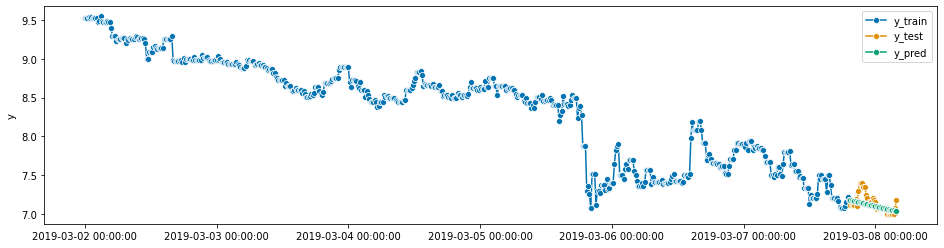

In [78]:
df = df_prices.asfreq("D", method='ffill')
df = df[['Close']].copy()
df.rename(columns={'Close': 'y'}, inplace=True)
df = df['y']
# df_train = df[df.index < TEST_DATE]['y']
# df_test = df[df.index >= TEST_DATE]['y']
# df_train, df_test

y_train, y_test = temporal_train_test_split(df, test_size=36)
#plot_series(y_train, y_test, labels=["y_train", "y_test"])
#print(y_train.shape[0], y_test.shape[0])

fh = np.arange(len(y_test)) + 1
#len(fh)

forecaster = ExponentialSmoothing(trend="add") #, seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_test, y_pred)


In [22]:
#for name in STOCKS:
#    df_stock = dataset[dataset['name'] == name]
#    stock_name, stock_code = df_stock.iloc[0]['name'], df_stock.iloc[0]['symbol']
#    print(f"{stock_name} - {stock_code}")
#    print("-" * 25)
#    
#    # Get stock prices
#    df = investpy.get_stock_historical_data(stock=stock_code,
#                                            country=COUNTRY,
#                                            from_date=FROM_DATE,
#                                            to_date=TO_DATE)
#    df.reset_index(inplace=True)
#    df = df[['Date','Close']].copy()
#    df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
#    df_train = df[df['ds'] < TEST_DATE]
#    df_test = df[df['ds'] >= TEST_DATE]
#    
#    # Train
#    model = Prophet()
#    #dtf, model = fit_prophet(df_train, df_test, model=model, freq="D", figsize=(20,15))
#    future = forecast_prophet(df, model, end=END_DATE, freq="D", zoom=20, figsize=(15,5))
#    
#    time.sleep(3)